In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astra
import os
from einops import rearrange
astra.test()

ASTRA Toolbox v2.1.0
Getting GPU info... GPU #0: NVIDIA GeForce GTX 1060 with Max-Q Design, with 6143MB
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [3]:
data_red = []
data_green = []

path_red_data = "data/RED/ScanData"
path_red_ref = "data/RED/ScanRef"
path_green_data = "data/GREEN/ScanData"
path_green_ref = "data/GREEN/ScanRef"

for data_name, ref_name in zip(os.listdir(path_red_data),os.listdir(path_red_ref)):
    with open(os.path.join(path_red_data, data_name), 'rb') as f_red:
        img_data_red = np.fromfile(f_red,np.uint16)[27:].reshape(480,640).T.astype(float)
    with open(os.path.join(path_red_ref, ref_name), 'rb') as f_red:
        img_ref_red = np.fromfile(f_red,np.uint16)[27:].reshape(480,640).T.astype(float)

    # data_red.append(img_ref_red-img_data_red)
    data_red.append(np.log10(img_ref_red/img_data_red))

for data_name, ref_name in zip(os.listdir(path_green_data),os.listdir(path_green_ref)):
    with open(os.path.join(path_green_data, data_name), 'rb') as f_green:
        img_data_green = np.fromfile(f_green,np.uint16)[27:].reshape(480,640).T
    with open(os.path.join(path_green_ref, ref_name), 'rb') as f_green:
        img_ref_green = np.fromfile(f_green,np.uint16)[27:].reshape(480,640).T

    # data_green.append(img_ref_green-img_data_green)
    data_green.append(np.log10(img_ref_green/img_data_green))

data_red = np.array(data_red)
# data_red = rearrange(data_red, "a b c -> b a c")
data_red = rearrange(data_red, "a b c -> c a b")
data_red = np.roll(data_red, int(-7), axis=2)
data_green = np.array(data_green)
# data_green = rearrange(data_green, "a b c -> b a c")
data_green = rearrange(data_green, "a b c -> c a b")
print(data_red.shape,data_green.shape)

(480, 320, 640) (480, 320, 640)


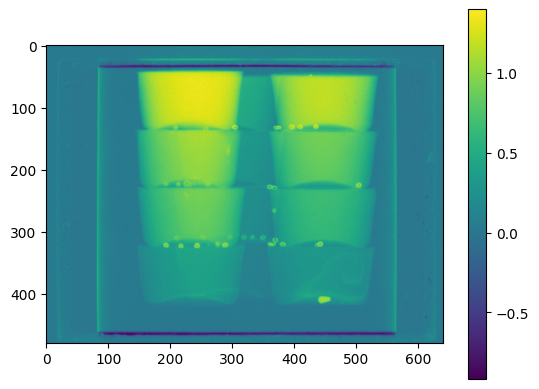

In [4]:
plt.imshow(data_red[:,160])
plt.colorbar()

In [10]:
HLS = 11.660455486542444
VLS = 8.7453416149068328
detector_pixel_size = HLS / 640 # VLS / 480
source_origin = 57.832814930015466/detector_pixel_size
origin_det = 4.5/detector_pixel_size

cone_geom_red = astra.create_proj_geom(
    'cone',
    0.7,
    0.7,
    480,
    640,
    np.linspace(0, 2*np.pi, 320, endpoint=False),
    source_origin,
    origin_det
)

sinogram_id = astra.data3d.create(datatype='-sino', data=data_red, geometry=cone_geom_red)
vol_geom = astra.create_vol_geom(640,640,640)
# cfg = astra.astra_dict('BP3D_CUDA')
cfg = astra.astra_dict('FDK_CUDA')
# cfg = astra.astra_dict('SIRT3D_CUDA')
# cfg = astra.astra_dict('CGLS3D_CUDA')
cfg['ReconstructionDataId'] = astra.data3d.create(datatype='-vol', geometry=vol_geom,data=0)
cfg['ProjectionDataId'] = sinogram_id
alg_id = astra.algorithm.create(cfg)


In [11]:
astra.algorithm.run(alg_id, 3)
recon = astra.data3d.get(cfg['ReconstructionDataId'])
sinogram = astra.data3d.get(cfg['ProjectionDataId'])
print(sinogram.shape,recon.shape)

(480, 320, 640) (640, 640, 640)


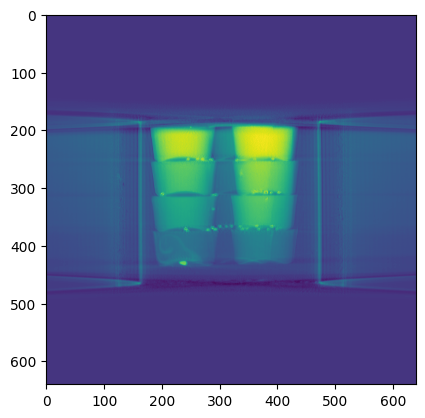

In [12]:
plt.imshow(recon.sum(axis=1))

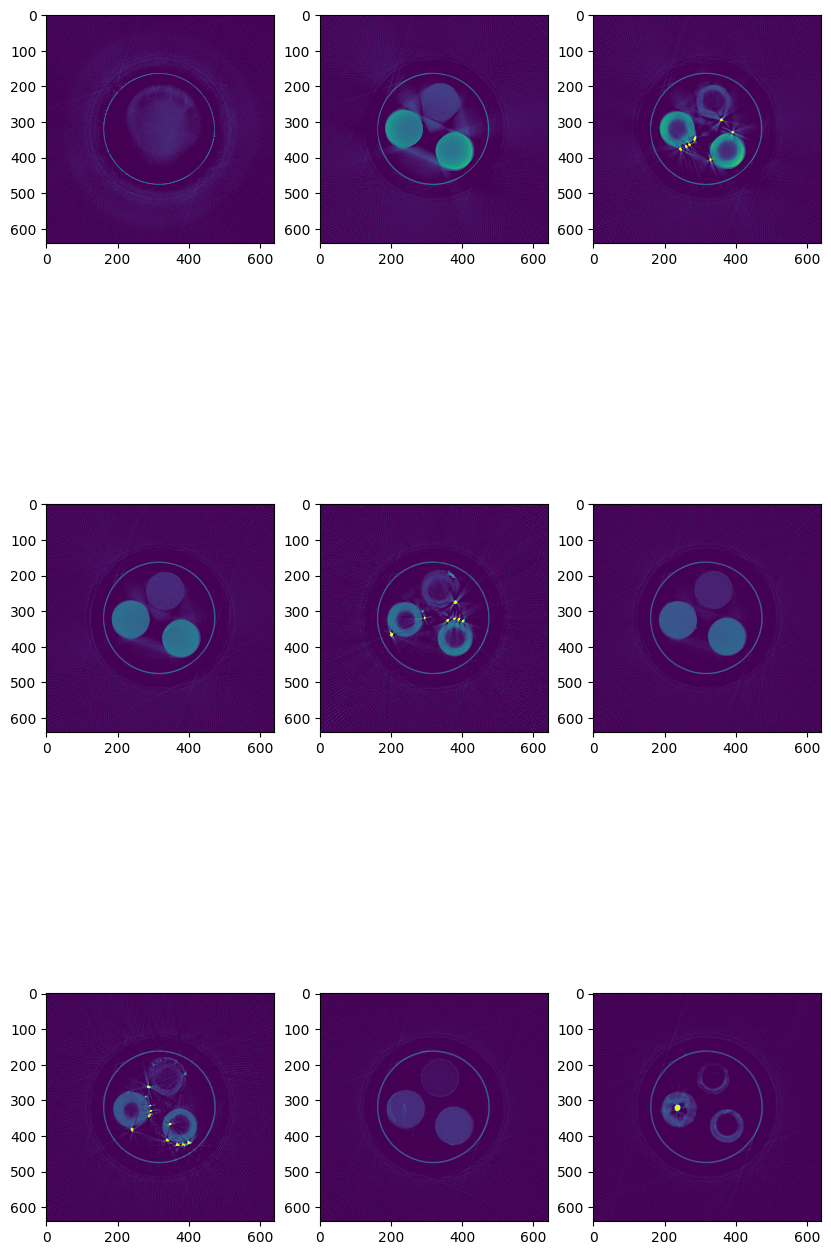

In [13]:
plt.figure(figsize=(10,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(recon[(i+1)*30+160,:])
# plt.imshow(recon.sum(axis=0))
    # plt.colorbar()
    plt.clim(0,0.02)
